#SISTEM REKOMENDASI FILM (MovieLens)

referensi dari: https://developers.google.com/machine-learning/recommendation/

dataset dari: https://movielens.org/
dan
https://grouplens.org/datasets/movielens/


langkah-langkah:
- Explore data
- Persiapan
- Training model matrix factorization
- Memeriksa sistem tersemat
- Regularisasi matrix factorization
- Training model softmax

### Import Library yang Dibutuhkan

In [1]:
from __future__ import print_function

import numpy as np
import pandas as pd
import collections
from mpl_toolkits.mplot3d import Axes3D
from IPython import display
from matplotlib import pyplot as plt
import sklearn
import sklearn.manifold
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()
tf.logging.set_verbosity(tf.logging.ERROR)

pd.options.display.max_rows = 10
pd.options.display.float_format = '{:.3f}'.format

def mask(df, key, function):

  return df[function(df[key])]


def flatten_cols(df):
  df.columns = [' '.join(col).strip() for col in df.columns.values]
  return df


pd.DataFrame.mask = mask
pd.DataFrame.flatten_cols = flatten_cols

#Install Altair dan mengaktifkan colab renderer
#Altair berfungsi untuk visualisasi statistik data
print("install altair....")
!pip install git+git://github.com/altair-viz/altair.git
import altair as alt
alt.data_transformers.enable('default', max_rows = None)
alt.renderers.enable('colab')
print("install altair sukses....")

#Install spreadsheets dan import modul untuk autentikasi
USER_RATINGS = False
!pip install --upgrade -q gspread
from google.colab import auth
import gspread
from oauth2client.client import GoogleCredentials

Instructions for updating:
non-resource variables are not supported in the long term


install altair....
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning git://github.com/altair-viz/altair.git to /tmp/pip-req-build-r49yc6ar
  Running command git clone -q git://github.com/altair-viz/altair.git /tmp/pip-req-build-r49yc6ar
  fatal: unable to connect to github.com:
  github.com[0: 140.82.112.4]: errno=Connection timed out

ERROR: Command errored out with exit status 128: git clone -q git://github.com/altair-viz/altair.git /tmp/pip-req-build-r49yc6ar Check the logs for full command output.
install altair sukses....


In [2]:
#Download dataset MovieLens
print("Download dataset MovieLens")
from urllib.request import urlretrieve
import zipfile

urlretrieve("http://files.grouplens.org/datasets/movielens/ml-100k.zip", "movielens.zip")
zip_ref = zipfile.ZipFile('movielens.zip', "r")
zip_ref.extractall()
print("Sukses, isi dataset: ")
print(zip_ref.read('ml-100k/u.info'))

Download dataset MovieLens
Sukses, isi dataset: 
b'943 users\n1682 items\n100000 ratings\n'


In [3]:
# Panggil setiap dataset (users, movies, ratings)

#dataset users
users_cols = ['user_id', 'age', 'sex', 'occupation', 'zip_code']
users = pd.read_csv('ml-100k/u.user', sep='|', names=users_cols, encoding='latin-1')

#dataset rating dari users
ratings_cols = ['user_id', 'movie_id', 'rating', 'unix_timestamp']
ratings = pd.read_csv(
    'ml-100k/u.data', sep='\t', names=ratings_cols, encoding='latin-1')

genre_cols = ["genre_unknown", "Action", "Adventure", "Animation", "Children", "Comedy",
    "Crime", "Documentary", "Drama", "Fantasy", "Film-Noir", "Horror",
    "Musical", "Mystery", "Romance", "Sci-Fi", "Thriller", "War", "Western"]


movies_cols = ['movie_id', 'title', 'release_date', "video_release_date", "imdb_url"] + genre_cols
movies = pd.read_csv('ml-100k/u.item', sep='|', names = movies_cols, encoding='latin-1')


In [4]:
# Karena id mulai dari 1, kita menggesernya menjadi mulai dari 0
users["user_id"] = users["user_id"].apply(lambda x: str(x-1))
movies["movie_id"] = movies["movie_id"].apply(lambda x: str(x-1))
movies["year"] = movies['release_date'].apply(lambda x: str(x).split('-')[-1])
ratings["movie_id"] = ratings["movie_id"].apply(lambda x: str(x-1))
ratings["user_id"] = ratings["user_id"].apply(lambda x: str(x-1))
ratings["rating"] = ratings["rating"].apply(lambda x: float(x))

In [5]:
#hitung jumlah film berdasarkan genre
genre_occurences = movies[genre_cols].sum().to_dict()
genre_occurences

{'genre_unknown': 2,
 'Action': 251,
 'Adventure': 135,
 'Animation': 42,
 'Children': 122,
 'Comedy': 505,
 'Crime': 109,
 'Documentary': 50,
 'Drama': 725,
 'Fantasy': 22,
 'Film-Noir': 24,
 'Horror': 92,
 'Musical': 56,
 'Mystery': 61,
 'Romance': 247,
 'Sci-Fi': 101,
 'Thriller': 251,
 'War': 71,
 'Western': 27}

In [6]:
# Tiap film bisa memiliki lebih dari 1 genre, maka 'genre' dimodifikasi sbg berikut:
# - all_genres: semua genre yang ada di suatu film (film yang punya semua genre)
# - genre: sample genre diabil secara acak dari genre yang aktif

def mark_genres(movies, genres):
  def get_random_genre(gs):
    active = [genre for genre, g in zip(genres, gs) if g==1]
    if len(active) == 0:
      return 'Other'
    return np.random.choice(active)

  def get_all_genres(gs):
    active = [genre for genre, g in zip(genres, gs) if g==1]
    if len(active) == 0:
      return 'Other'
    return '-'.join(active)

  movies['genre'] = [get_random_genre(gs) for gs in zip(*[movies[genre] for genre in genres])]
  movies['all_genres'] = [get_all_genres(gs) for gs in zip(*[movies[genre] for genre in genres])]

mark_genres(movies, genre_cols)


# Buat gabungan DataFrame dengan gabungan semua data MovieLens
movielens = ratings.merge(movies, on='movie_id').merge(users, on='user_id')

# Utility to split the data into training and test sets.
def split_dataframe(df, holdout_fraction=0.1):
  """Splits a DataFrame into training and test sets.
  Args:
    df: a dataframe.
    holdout_fraction: fraction of dataframe rows to use in the test set.
  Returns:
    train: dataframe for training
    test: dataframe for testing
  """
  test = df.sample(frac=holdout_fraction, replace=False)
  train = df[~df.index.isin(test.index)]
  return train, test

In [7]:
movielens.head()

,user_id,movie_id,rating,unix_timestamp,title,release_date,video_release_date,imdb_url,genre_unknown,Action,...,Thriller,War,Western,year,genre,all_genres,age,sex,occupation,zip_code
0,195,241,3.000,881250949,Kolya (1996),24-Jan-1997,NaN,http://us.imdb.com/M/title-exact?Kolya%20(1996),0,0,...,0,0,0,1997,Comedy,Comedy,49,M,writer,55105
1,195,256,2.000,881251577,Men in Black (1997),04-Jul-1997,NaN,http://us.imdb.com/M/title-exact?Men+in+Black+...,0,1,...,0,0,0,1997,Adventure,Action-Adventure-Comedy-Sci-Fi,49,M,writer,55105
2,195,110,4.000,881251793,"Truth About Cats & Dogs, The (1996)",26-Apr-1996,NaN,http://us.imdb.com/M/title-exact?Truth%20About...,0,0,...,0,0,0,1996,Comedy,Comedy-Romance,49,M,writer,55105
3,195,24,4.000,881251955,"Birdcage, The (1996)",08-Mar-1996,NaN,"http://us.imdb.com/M/title-exact?Birdcage,%20T...",0,0,...,0,0,0,1996,Comedy,Comedy,49,M,writer,55105
4,195,381,4.000,881251843,"Adventures of Priscilla, Queen of the Desert, ...",01-Jan-1994,NaN,http://us.imdb.com/M/title-exact?Adventures%20...,0,0,...,0,0,0,1994,Drama,Comedy-Drama,49,M,writer,55105


## Eksplorasi Data

### Users
Mulai dengan melihat statistik dari data numerik

In [8]:
users



,user_id,age,sex,occupation,zip_code
0,0,24,M,technician,85711
1,1,53,F,other,94043
2,2,23,M,writer,32067
3,3,24,M,technician,43537
4,4,33,F,other,15213
...,...,...,...,...,...
938,938,26,F,student,33319
939,939,32,M,administrator,02215
940,940,20,M,student,97229
941,941,48,F,librarian,78209


In [9]:
users.describe()

,age
count,943.000
mean,34.052
std,12.193
min,7.000
25%,25.000
50%,31.000
75%,43.000
max,73.000


informasi dari tabel di atas:
- rata-rata pengguna berusia 34 tahun
- usia paling muda 7 tahun, paling tua 73 tahun

In [10]:
 #membuat chart berdasarkan occupation (pekerjaan)
occupation_filter = alt.selection_multi(fields=["occupation"])
occupation_chart = alt.Chart().mark_bar().encode(
    x="count()",
    y=alt.Y("occupation:N"),
    color=alt.condition(
        occupation_filter,
        alt.Color("occupation:N", scale=alt.Scale(scheme='category20')),
        alt.value("lightgray")),
).properties(width=300, height=300, selection=occupation_filter)

In [11]:
# fungsi untuk menghasilkan histogram
def filtered_hist(field, label, filter):
  """Creates a layered chart of histograms.
  The first layer (light gray) contains the histogram of the full data, and the
  second contains the histogram of the filtered data.
  Args:
    field: the field for which to generate the histogram.
    label: String label of the histogram.
    filter: an alt.Selection object to be used to filter the data.
  """
  base = alt.Chart().mark_bar().encode(
      x=alt.X(field, bin=alt.Bin(maxbins=10), title=label),
      y="count()",
  ).properties(
      width=300,
  )
  return alt.layer(
      base.transform_filter(filter),
      base.encode(color=alt.value('lightgray'), opacity=alt.value(.7)),
  ).resolve_scale(y='independent')

In [12]:
#melihat distribusi dari tiap pengguna berdasarkan occupation (pekerjaan)
users_ratings = (
    ratings
    .groupby('user_id', as_index=False)
    .agg({'rating': ['count', 'mean']})
    .flatten_cols()
    .merge(users, on='user_id')
)

# Create a chart for the count, and one for the mean.
alt.hconcat(
    filtered_hist('rating count', '# ratings / user', occupation_filter),
    filtered_hist('rating mean', 'mean user rating', occupation_filter),
    occupation_chart,
    data=users_ratings)

alt.HConcatChart(...)

### Movies
melihat informasi tentang film dan peringkatnya

In [13]:
movies_ratings = movies.merge(
    ratings
    .groupby('movie_id', as_index=False)
    .agg({'rating': ['count', 'mean']})
    .flatten_cols(),
    on='movie_id')


genre_filter = alt.selection_multi(fields=['genre'])
genre_chart = alt.Chart().mark_bar().encode(
    x="count()",
    y=alt.Y('genre'),
    color=alt.condition(
        genre_filter,
        alt.Color("genre:N"),
        alt.value('lightgray'))
).properties(height=300, selection=genre_filter)


In [14]:
(movies_ratings[['title', 'rating count', 'rating mean']]
 .sort_values('rating count', ascending=False)
 .head(10))

,title,rating count,rating mean
49,Star Wars (1977),583,4.358
257,Contact (1997),509,3.804
99,Fargo (1996),508,4.156
180,Return of the Jedi (1983),507,4.008
293,Liar Liar (1997),485,3.157
285,"English Patient, The (1996)",481,3.657
287,Scream (1996),478,3.441
0,Toy Story (1995),452,3.878
299,Air Force One (1997),431,3.631
120,Independence Day (ID4) (1996),429,3.438


In [15]:
(movies_ratings[['title', 'rating count', 'rating mean']]
 .mask('rating count', lambda x: x > 20)
 .sort_values('rating mean', ascending=False)
 .head(10))

,title,rating count,rating mean
407,"Close Shave, A (1995)",112,4.491
317,Schindler's List (1993),298,4.466
168,"Wrong Trousers, The (1993)",118,4.466
482,Casablanca (1942),243,4.457
113,Wallace & Gromit: The Best of Aardman Animatio...,67,4.448
63,"Shawshank Redemption, The (1994)",283,4.445
602,Rear Window (1954),209,4.388
11,"Usual Suspects, The (1995)",267,4.386
49,Star Wars (1977),583,4.358
177,12 Angry Men (1957),125,4.344


In [16]:
# Menampilkan jumlah peringkat dan peringkat rata-rata per film
alt.concat(
    filtered_hist('rating count', '# ratings / movie', genre_filter),
    filtered_hist('rating mean', 'mean movie rating', genre_filter),
    genre_chart,
    data =  movies_ratings
)

alt.ConcatChart(...)

## Persiapan

### Latihan 1 : Representasi tf.SparseTensor dari Matrix Rating

In [17]:
def build_rating_sparse_tensor(ratings_df):
  """
  Args:
    ratings_df: a pd.DataFrame with `user_id`, `movie_id` and `rating` columns.
  Returns:
    a tf.SparseTensor representing the ratings matrix.
  """
  indices = ratings_df[['user_id', 'movie_id']].values
  values = ratings_df['rating'].values
  return tf.SparseTensor(
      indices=indices,
      values=values,
      dense_shape=[users.shape[0], movies.shape[0]])

### Latihan 2: Mean Squared Error
menghitung nilai loss

In [18]:
def sparse_mean_square_error(sparse_ratings, user_embeddings, movie_embeddings):

  predictions = tf.gather_nd(
      tf.matmul(user_embeddings, movie_embeddings, transpose_b =  True), sparse_ratings.indices)

  loss = tf.losses.mean_squared_error(sparse_ratings.values, predictions)
  return loss

In [19]:
def sparse_mean_square_error(sparse_ratings, user_embeddings, movie_embeddings):
  """
  Args:
    sparse_ratings: A SparseTensor rating matrix, of dense_shape [N, M]
    user_embeddings: A dense Tensor U of shape [N, k] where k is the embedding
      dimension, such that U_i is the embedding of user i.
    movie_embeddings: A dense Tensor V of shape [M, k] where k is the embedding
      dimension, such that V_j is the embedding of movie j.
  Returns:
    A scalar Tensor representing the MSE between the true ratings and the
      model's predictions.
  """
  predictions = tf.reduce_sum(
      tf.gather(user_embeddings, sparse_ratings.indices[:, 0]) *
      tf.gather(movie_embeddings, sparse_ratings.indices[:, 1]),
      axis=1)
  loss = tf.losses.mean_squared_error(sparse_ratings.values, predictions)
  return loss

### Latihan 3 (opsional) 

## Training Model Matrix Factorization

In [20]:
# title CFModel helper class (run this cell)
class CFModel(object):
  """Simple class that represents a collaborative filtering model"""
  def __init__(self, embedding_vars, loss, metrics=None):
    """Initializes a CFModel.
    Args:
      embedding_vars: A dictionary of tf.Variables.
      loss: A float Tensor. The loss to optimize.
      metrics: optional list of dictionaries of Tensors. The metrics in each
        dictionary will be plotted in a separate figure during training.
    """
    self._embedding_vars = embedding_vars
    self._loss = loss
    self._metrics = metrics
    self._embeddings = {k: None for k in embedding_vars}
    self._session = None

  @property
  def embeddings(self):
    """The embeddings dictionary."""
    return self._embeddings

  def train(self, num_iterations=100, learning_rate=1.0, plot_results=True,
            optimizer=tf.train.GradientDescentOptimizer):
    """Trains the model.
    Args:
      iterations: number of iterations to run.
      learning_rate: optimizer learning rate.
      plot_results: whether to plot the results at the end of training.
      optimizer: the optimizer to use. Default to GradientDescentOptimizer.
    Returns:
      The metrics dictionary evaluated at the last iteration.
    """
    with self._loss.graph.as_default():
      opt = optimizer(learning_rate)
      train_op = opt.minimize(self._loss)
      local_init_op = tf.group(
          tf.variables_initializer(opt.variables()),
          tf.local_variables_initializer())
      if self._session is None:
        self._session = tf.Session()
        with self._session.as_default():
          self._session.run(tf.global_variables_initializer())
          self._session.run(tf.tables_initializer())
          tf.train.start_queue_runners()

    with self._session.as_default():
      local_init_op.run()
      iterations = []
      metrics = self._metrics or ({},)
      metrics_vals = [collections.defaultdict(list) for _ in self._metrics]

      # Train and append results.
      for i in range(num_iterations + 1):
        _, results = self._session.run((train_op, metrics))
        if (i % 10 == 0) or i == num_iterations:
          print("\r iteration %d: " % i + ", ".join(
                ["%s=%f" % (k, v) for r in results for k, v in r.items()]),
                end='')
          iterations.append(i)
          for metric_val, result in zip(metrics_vals, results):
            for k, v in result.items():
              metric_val[k].append(v)

      for k, v in self._embedding_vars.items():
        self._embeddings[k] = v.eval()

      if plot_results:
        # Plot the metrics.
        num_subplots = len(metrics)+1
        fig = plt.figure()
        fig.set_size_inches(num_subplots*10, 8)
        for i, metric_vals in enumerate(metrics_vals):
          ax = fig.add_subplot(1, num_subplots, i+1)
          for k, v in metric_vals.items():
            ax.plot(iterations, v, label=k)
          ax.set_xlim([1, num_iterations])
          ax.legend()
      return results

### Latihan 4 : Membuat model 

In [21]:
def build_model(ratings, embedding_dim=3, init_stddev=1.):
  train_ratings, test_ratings = split_dataframe(ratings)

  A_train = build_rating_sparse_tensor(train_ratings)
  A_test = build_rating_sparse_tensor(train_ratings)

  U = tf.Variable(tf.random_normal(
      [A_train.dense_shape[0], embedding_dim], stddev=init_stddev))
  V = tf.Variable(tf.random_normal(
      [A_train.dense_shape[1], embedding_dim], stddev=init_stddev))
  
  train_loss = sparse_mean_square_error(A_train, U, V)
  test_loss = sparse_mean_square_error(A_test, U, V)

  metrics = {'train_error': train_loss, 'test_error': test_loss}

  embeddings = {"user_id":U, "movie_id": V}

  return CFModel(embeddings, train_loss, [metrics])


 iteration 1000: train_error=0.372084, test_error=0.372084

[{'train_error': 0.3720836, 'test_error': 0.3720836}]

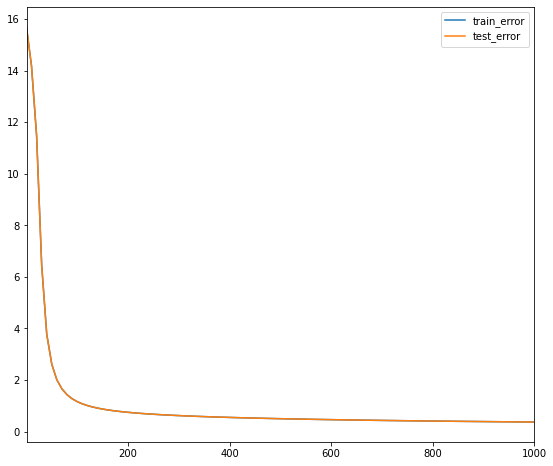

In [22]:
model = build_model(ratings, embedding_dim=30, init_stddev=0.5)
model.train(num_iterations=1000, learning_rate=10.)

### Latihan 5 : membuat fungsi untuk menghitung nilai kandidat film lain

In [23]:
DOT = 'dot'
COSINE = 'cosine'

def compute_scores(query_embedding, item_embeddings, measure = DOT):
  u = query_embedding
  V = item_embeddings
  
  if measure == COSINE:
    V = V / np.linalg.norm(V, axis=1, keepdims=True)
    u = u / np.linalg.norm(u)
  scores = u.dot(V.T)
  return scores

In [24]:
# Rekomendasi dengan KNN (K-Nearest Neighbors)

def movie_neighbors(model, title_substring, measure=DOT, k=5):
  # nilai k berpengaruh pada jumlah rekomendasi yang akan muncul
  # measure = DOT dapat diubah ke COSINE atau dikosongkan, namun harus diinput saat menjalankan fungsi
  ids =  movies[movies['title'].str.contains(title_substring)].index.values
  titles = movies.iloc[ids]['title'].values

  # output error jika tidak ada judul yang dicari
  if len(titles) == 0:
    raise ValueError("Found no movies with title %s" % title_substring)

  print("Nearest neighbors of : %s." % titles[0])

  #memunculkan judul lain jika ada kata kunci yang sama
  if len(titles) > 1:
    print("[Found more than one matching movie. Other candidates: {}]".format(
        ", ".join(titles[1:])))
    
  movie_id = ids[0]
  scores = compute_scores(model.embeddings["movie_id"][movie_id], model.embeddings["movie_id"], measure)
  score_key = measure + ' score'
  df = pd.DataFrame({
      score_key: list(scores),
      'titles': movies['title'],
      'genres': movies['all_genres']
  })
  display.display(df.sort_values([score_key], ascending=False).head(k))


In [25]:
movie_neighbors(model, "Alone", DOT)
movie_neighbors(model, "Aladdin", COSINE)

Nearest neighbors of : Home Alone (1990).
[Found more than one matching movie. Other candidates: Home Alone 3 (1997)]


,dot score,titles,genres
93,6.904,Home Alone (1990),Children-Comedy
1014,5.209,Shiloh (1997),Children-Drama
954,5.187,Before Sunrise (1995),Drama-Romance
72,5.183,Maverick (1994),Action-Comedy-Western
1619,5.091,"Sixth Man, The (1997)",Comedy


Nearest neighbors of : Aladdin (1992).
[Found more than one matching movie. Other candidates: Aladdin and the King of Thieves (1996)]


,cosine score,titles,genres
94,1.000,Aladdin (1992),Animation-Children-Comedy-Musical
78,0.851,"Fugitive, The (1993)",Action-Thriller
209,0.844,Indiana Jones and the Last Crusade (1989),Action-Adventure
70,0.833,"Lion King, The (1994)",Animation-Children-Musical
0,0.818,Toy Story (1995),Animation-Children-Comedy


 iteration 1000: train_error=0.696143, test_error=0.696143

[{'train_error': 0.6961434, 'test_error': 0.6961434}]

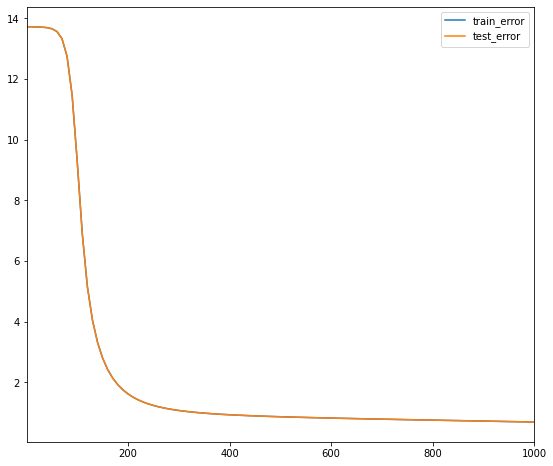

In [26]:
model_lowinit = build_model(ratings, embedding_dim=30, init_stddev=0.05)
model_lowinit.train(num_iterations=1000, learning_rate=4)

In [27]:
movie_neighbors(model_lowinit, "Aladdin", DOT)
movie_neighbors(model_lowinit, "Aladdin", COSINE)

Nearest neighbors of : Aladdin (1992).
[Found more than one matching movie. Other candidates: Aladdin and the King of Thieves (1996)]


,dot score,titles,genres
49,4.708,Star Wars (1977),Action-Adventure-Romance-Sci-Fi-War
63,4.704,"Shawshank Redemption, The (1994)",Drama
21,4.702,Braveheart (1995),Action-Drama-War
173,4.605,Raiders of the Lost Ark (1981),Action-Adventure
180,4.600,Return of the Jedi (1983),Action-Adventure-Romance-Sci-Fi-War


Nearest neighbors of : Aladdin (1992).
[Found more than one matching movie. Other candidates: Aladdin and the King of Thieves (1996)]


,cosine score,titles,genres
94,1.000,Aladdin (1992),Animation-Children-Comedy-Musical
62,0.960,"Santa Clause, The (1994)",Children-Comedy
1050,0.958,"Associate, The (1996)",Comedy
731,0.956,Dave (1993),Comedy-Romance
539,0.955,Money Train (1995),Action


In [29]:
def movie_embedding_norm(models):
  """Visualizes the norm and number of ratings of the movie embeddings.
  Args:
    model: A MFModel object.
  """
  if not isinstance(models, list):
    models = [models]
  df = pd.DataFrame({
      'title': movies['title'],
      'genre': movies['genre'],
      'num_ratings': movies_ratings['rating count'],
  })
  charts = []
  brush = alt.selection_interval()
  for i, model in enumerate(models):
    norm_key = 'norm'+str(i)
    df[norm_key] = np.linalg.norm(model.embeddings["movie_id"], axis=1)
    nearest = alt.selection(
        type='single', encodings=['x', 'y'], on='mouseover', nearest=True,
        empty='none')
    base = alt.Chart().mark_circle().encode(
        x='num_ratings',
        y=norm_key,
        color=alt.condition(brush, alt.value('#4c78a8'), alt.value('lightgray'))
    ).properties(
        selection=nearest).add_selection(brush)
    text = alt.Chart().mark_text(align='center', dx=5, dy=-5).encode(
        x='num_ratings', y=norm_key,
        text=alt.condition(nearest, 'title', alt.value('')))
    charts.append(alt.layer(base, text))
  return alt.hconcat(*charts, data=df)

 iteration 1000: train_error=0.354605, test_error=0.354605Nearest neighbors of : Aladdin (1992).
[Found more than one matching movie. Other candidates: Aladdin and the King of Thieves (1996)]


,dot score,titles,genres
94,5.478,Aladdin (1992),Animation-Children-Comedy-Musical
142,5.055,"Sound of Music, The (1965)",Musical
0,4.996,Toy Story (1995),Animation-Children-Comedy
422,4.996,E.T. the Extra-Terrestrial (1982),Children-Drama-Fantasy-Sci-Fi
63,4.892,"Shawshank Redemption, The (1994)",Drama


Nearest neighbors of : Aladdin (1992).
[Found more than one matching movie. Other candidates: Aladdin and the King of Thieves (1996)]


,cosine score,titles,genres
94,1.000,Aladdin (1992),Animation-Children-Comedy-Musical
1278,0.888,Wild America (1997),Adventure-Children
624,0.868,"Sword in the Stone, The (1963)",Animation-Children
365,0.832,Dangerous Minds (1995),Drama
1189,0.831,That Old Feeling (1997),Comedy-Romance


alt.HConcatChart(...)

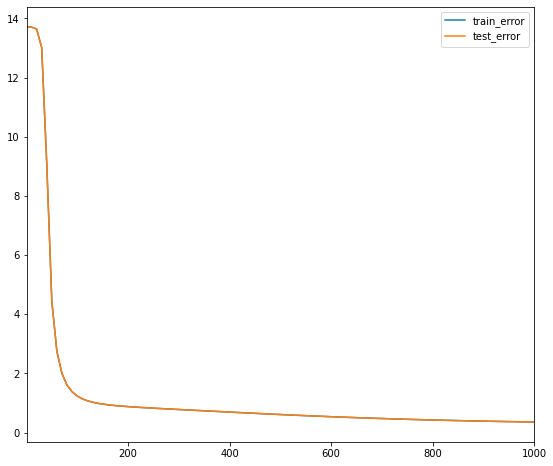

In [30]:
model_lowinit = build_model(ratings, embedding_dim=30, init_stddev=0.05)
model_lowinit.train(num_iterations=1000, learning_rate=10.)
movie_neighbors(model_lowinit, "Aladdin", DOT)
movie_neighbors(model_lowinit, "Aladdin", COSINE)
movie_embedding_norm([model, model_lowinit])

### Latihan 6: Membuat model Regularisasi Matrix Factorization

In [31]:
# title Solution
def gravity(U, V):
  """Creates a gravity loss given two embedding matrices."""
  return 1. / (U.shape[0].value*V.shape[0].value) * tf.reduce_sum(
      tf.matmul(U, U, transpose_a=True) * tf.matmul(V, V, transpose_a=True))

def build_regularized_model(
    ratings, embedding_dim=3, regularization_coeff=.1, gravity_coeff=1.,
    init_stddev=0.1):
  """
  Args:
    ratings: the DataFrame of movie ratings.
    embedding_dim: The dimension of the embedding space.
    regularization_coeff: The regularization coefficient lambda.
    gravity_coeff: The gravity regularization coefficient lambda_g.
  Returns:
    A CFModel object that uses a regularized loss.
  """
  # Split the ratings DataFrame into train and test.
  train_ratings, test_ratings = split_dataframe(ratings)
  # SparseTensor representation of the train and test datasets.
  A_train = build_rating_sparse_tensor(train_ratings)
  A_test = build_rating_sparse_tensor(test_ratings)
  U = tf.Variable(tf.random_normal(
      [A_train.dense_shape[0], embedding_dim], stddev=init_stddev))
  V = tf.Variable(tf.random_normal(
      [A_train.dense_shape[1], embedding_dim], stddev=init_stddev))

  error_train = sparse_mean_square_error(A_train, U, V)
  error_test = sparse_mean_square_error(A_test, U, V)
  gravity_loss = gravity_coeff * gravity(U, V)
  regularization_loss = regularization_coeff * (
      tf.reduce_sum(U*U)/U.shape[0].value + tf.reduce_sum(V*V)/V.shape[0].value)
  total_loss = error_train + regularization_loss + gravity_loss
  losses = {
      'train_error_observed': error_train,
      'test_error_observed': error_test,
  }
  loss_components = {
      'observed_loss': error_train,
      'regularization_loss': regularization_loss,
      'gravity_loss': gravity_loss,
  }
  embeddings = {"user_id": U, "movie_id": V}

  return CFModel(embeddings, total_loss, [losses, loss_components])

 iteration 2000: train_error_observed=1.000094, test_error_observed=2.478187, observed_loss=1.000094, regularization_loss=0.852078, gravity_loss=1.315477

[{'train_error_observed': 1.0000944, 'test_error_observed': 2.4781866},
 {'observed_loss': 1.0000944,
  'regularization_loss': 0.8520781,
  'gravity_loss': 1.3154768}]

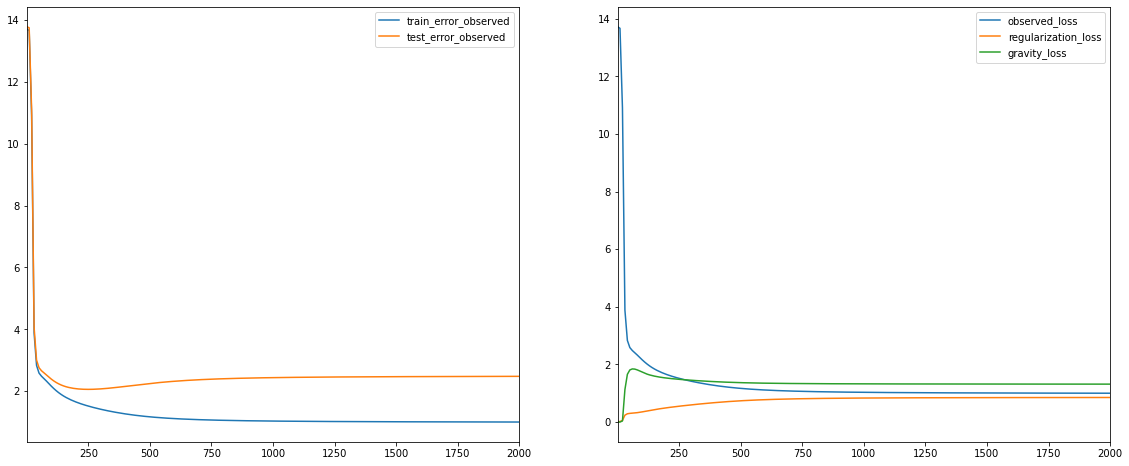

In [32]:
reg_model = build_regularized_model(
    ratings, regularization_coeff=0.1, gravity_coeff=1.0, embedding_dim=35,
    init_stddev=.05)
reg_model.train(num_iterations=2000, learning_rate=20.)

In [33]:
# cek hasilnya
movie_neighbors(reg_model, "Aladdin", DOT)
movie_neighbors(reg_model, "Aladdin", COSINE)

Nearest neighbors of : Aladdin (1992).
[Found more than one matching movie. Other candidates: Aladdin and the King of Thieves (1996)]


,dot score,titles,genres
94,8.913,Aladdin (1992),Animation-Children-Comedy-Musical
70,8.006,"Lion King, The (1994)",Animation-Children-Musical
587,7.746,Beauty and the Beast (1991),Animation-Children-Musical
173,7.406,Raiders of the Lost Ark (1981),Action-Adventure
171,7.273,"Empire Strikes Back, The (1980)",Action-Adventure-Drama-Romance-Sci-Fi-War


Nearest neighbors of : Aladdin (1992).
[Found more than one matching movie. Other candidates: Aladdin and the King of Thieves (1996)]


,cosine score,titles,genres
94,1.000,Aladdin (1992),Animation-Children-Comedy-Musical
70,0.872,"Lion King, The (1994)",Animation-Children-Musical
587,0.861,Beauty and the Beast (1991),Animation-Children-Musical
417,0.798,Cinderella (1950),Animation-Children-Musical
81,0.769,Jurassic Park (1993),Action-Adventure-Sci-Fi
